# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [3]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_3444\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_3444\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [4]:
list_25l.shape

(25, 120, 118)

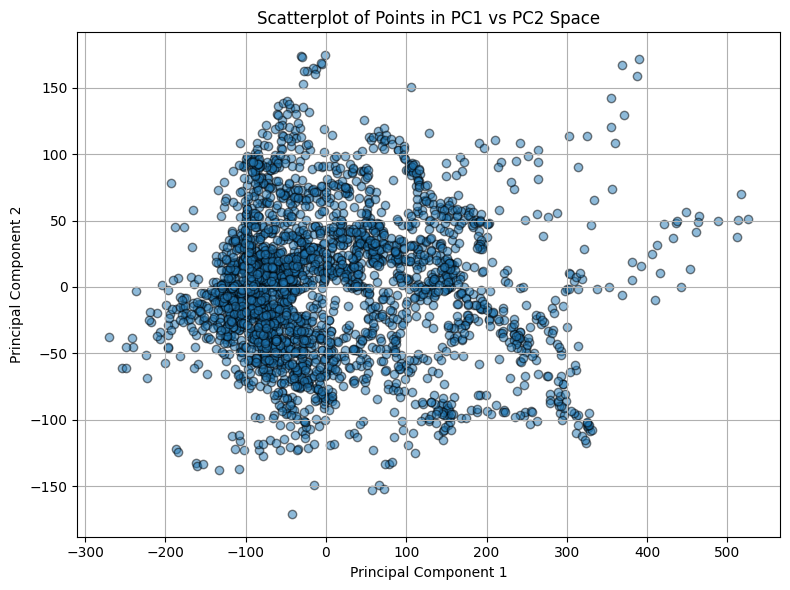

In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def global_pca(list_25l, n_components=0.90):
    # Step 1: Stack all matrices vertically
    X_all = np.vstack(list_25l)  # shape: (25*M, N)

    # Step 2: Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_all)
    std_devs = np.sqrt(pca.explained_variance_)
    # Step 3: Extract points in PC1 and PC2 space
    pc1 = X_pca[:, 0]
    pc2 = X_pca[:, 1]

    # Step 4: Scatterplot of PC1 vs PC2
    plt.figure(figsize=(8, 6))
    plt.scatter(pc1, pc2, alpha=0.5, edgecolor='k')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Scatterplot of Points in PC1 vs PC2 Space')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pc1, pc2
pc1, pc2 = global_pca(list_25l)


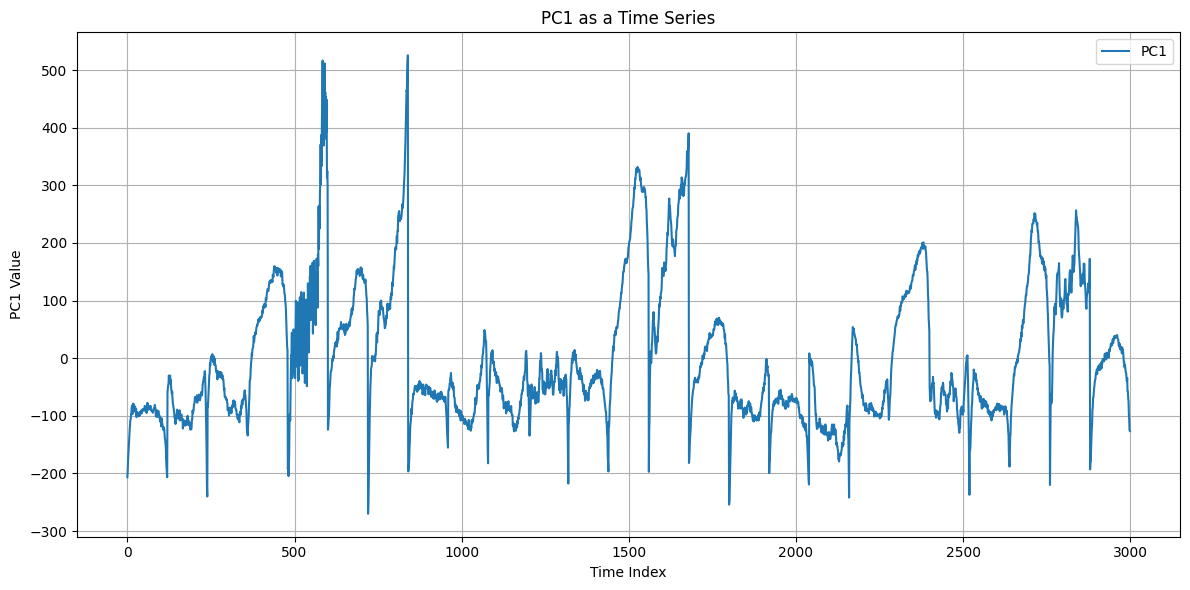

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(pc1, label='PC1')
plt.xlabel('Time Index')
plt.ylabel('PC1 Value')
plt.title('PC1 as a Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

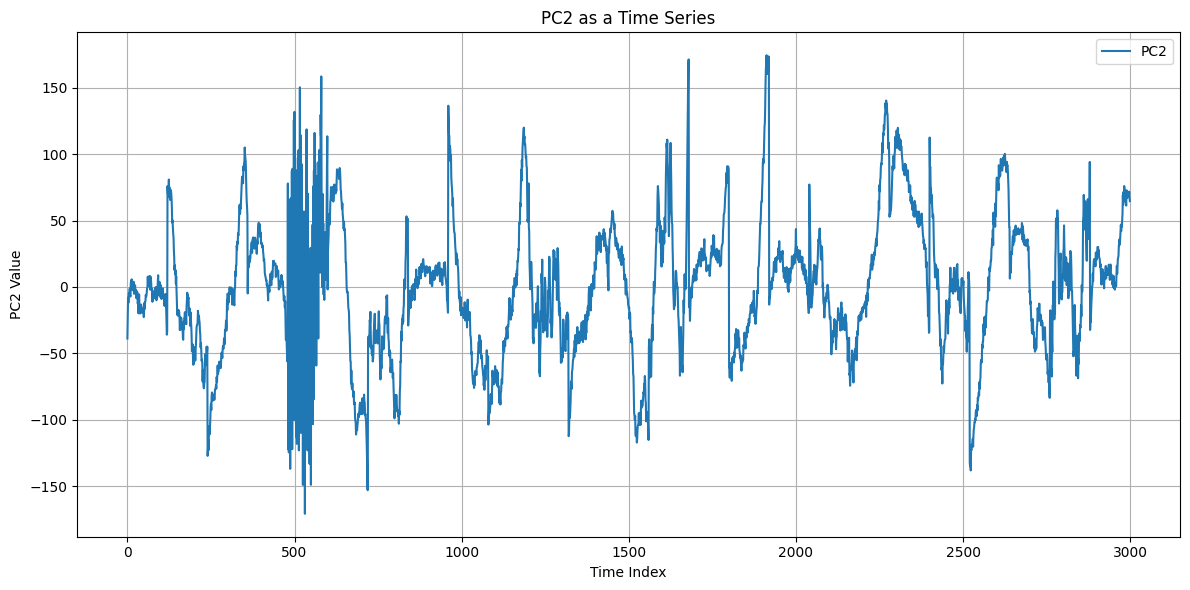

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(pc2, label='PC2')
plt.xlabel('Time Index')
plt.ylabel('PC2 Value')
plt.title('PC2 as a Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\qdatoolkit\models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


Runs test statistic = -51.368
Runs test p-value = 0.000



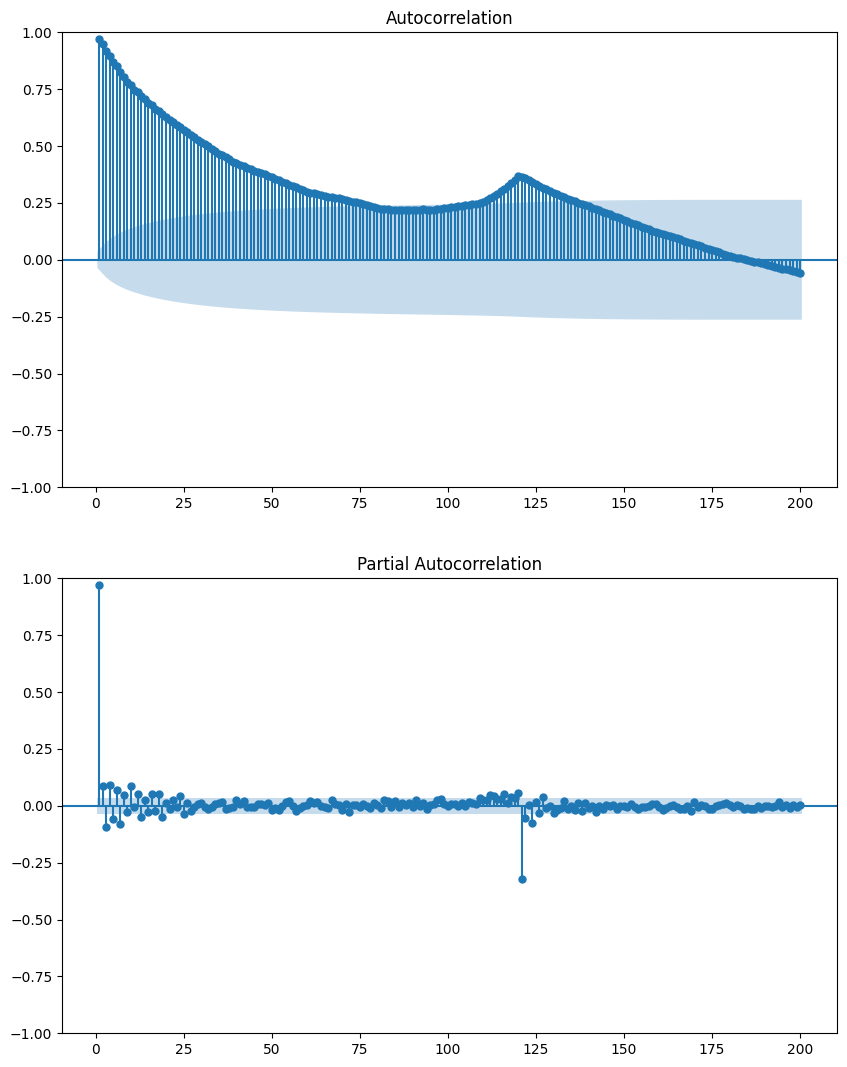

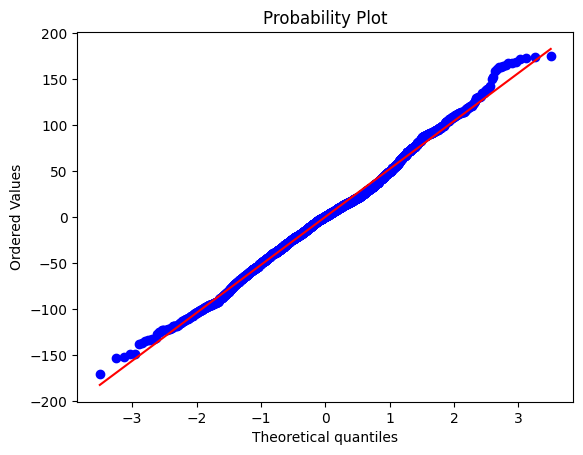

Shapiro-wilk test statistic = 0.996
Shapiro-wilk test p-value = 0.000


In [7]:
import qdatoolkit as qda
runs_statistic, runs_pvalue = qda.Assumptions(pc1).independence()

sw_statistic, sw_pvalue = qda.Assumptions(pc2).normality()

rowwise pca and hotelling

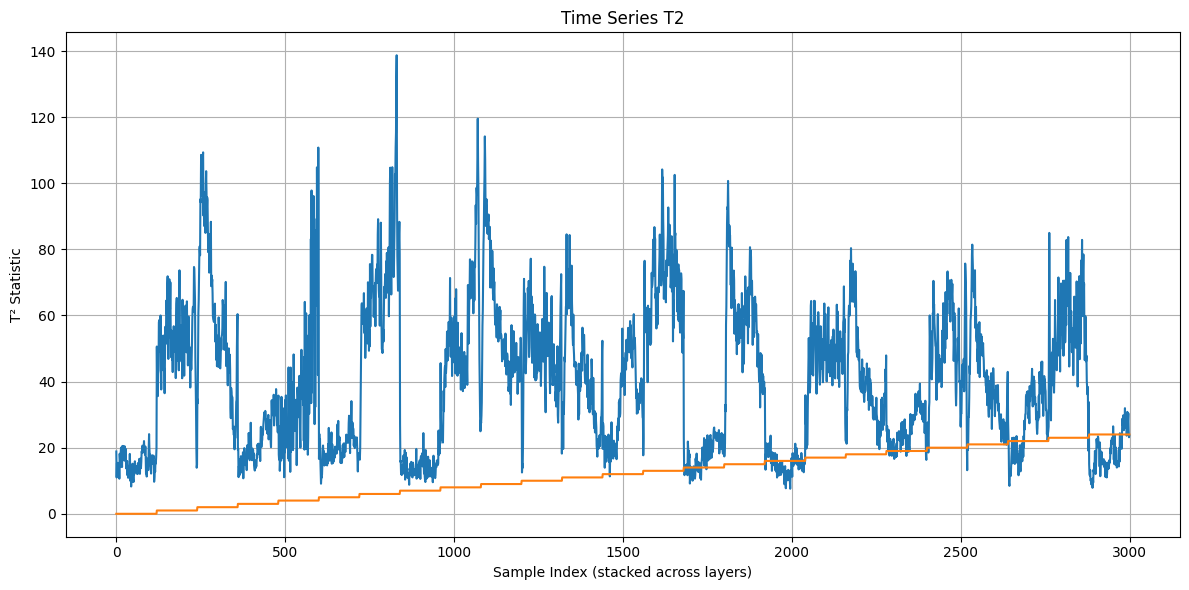

In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def global_pca_hotelling_df(list_25l, n_components=0.90):
    # Step 1: Stack all matrices vertically
    X_all = np.vstack(list_25l)  # shape: (25*M, N)

    # Step 2: Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_all)
    std_devs = np.sqrt(pca.explained_variance_)

    # Step 3: Compute Hotelling T²
    T2 = np.sum((X_pca / std_devs) ** 2, axis=1)

    # Step 4: Build matrix index column
    rows_per_matrix = list_25l[0].shape[0]
    matrix_indices = np.concatenate([
        np.full(rows_per_matrix, i) for i in range(len(list_25l))
    ])

    # Step 5: Return DataFrame
    df = pd.DataFrame({
        'T2': T2,
        'layer_id': matrix_indices
    })
    return df
output = global_pca_hotelling_df(list_25l)

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(output, label='Hotelling T²')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('T² Statistic')
plt.title('Time Series T2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
pca_rowwise_df = pd.read_csv("data/pca_rowwise.csv")
pca_rowwise_df['T2_diff'] = pca_rowwise_df['T2'].diff()
pca_rowwise_df['layer_change'] = (pca_rowwise_df['layer_id'].diff() != 0).astype(int)
pca_rowwise_df['t'] = pca_rowwise_df.index
layer_dummies = pd.get_dummies(pca_rowwise_df['layer_id'], prefix='layer')
pca_rowwise_df = pd.concat([pca_rowwise_df, layer_dummies], axis=1)
pca_rowwise_df = pca_rowwise_df.iloc[1:].reset_index(drop=True)
pca_rowwise_df.head()

,T2,layer_id,T2_diff,layer_change,t,layer_0,layer_1,layer_2,layer_3,layer_4,...,layer_15,layer_16,layer_17,layer_18,layer_19,layer_20,layer_21,layer_22,layer_23,layer_24
0,10.979106,0,-7.868585,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.267905,0,4.288800,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.919741,0,-2.348164,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15.405597,0,2.485856,0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.119495,0,-1.286102,0,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Runs test statistic = 13.570
Runs test p-value = 0.000



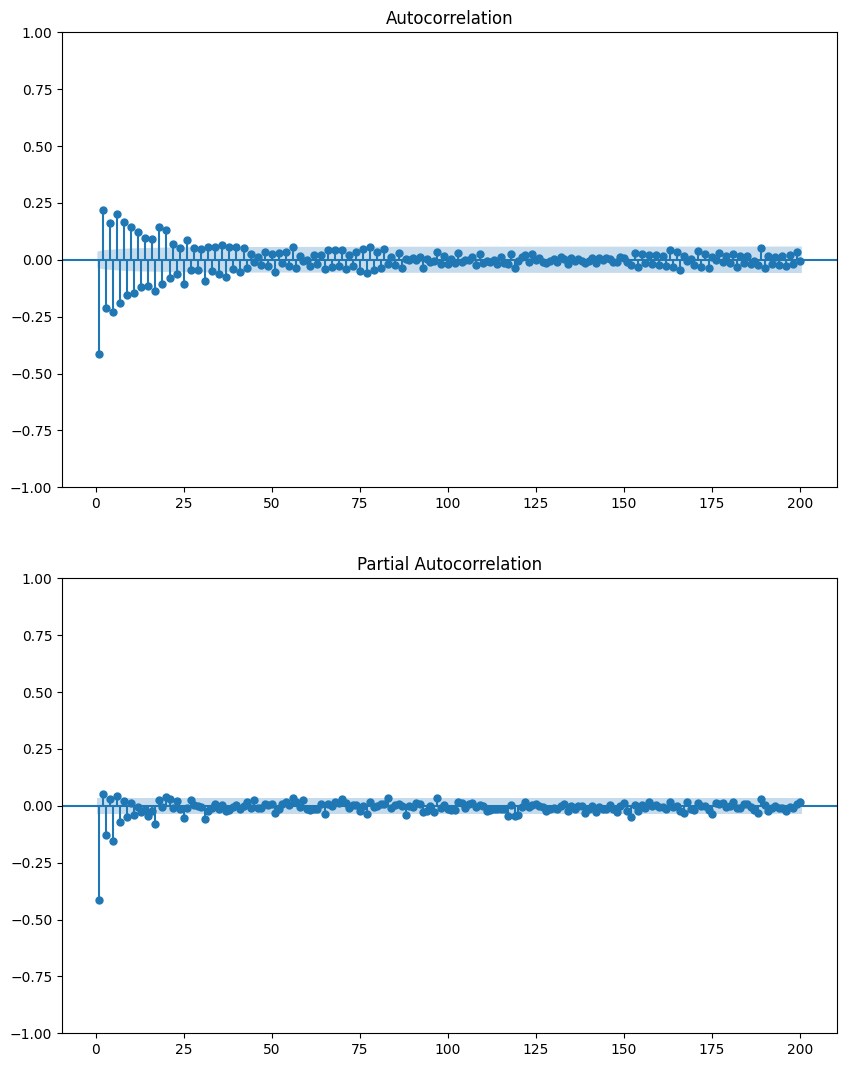

In [18]:
import qdatoolkit as qda
runs_statistic, runs_pvalue = qda.Assumptions(pca_rowwise_df['T2_diff']).independence()

                            AutoReg Model Results                             
Dep. Variable:                T2_diff   No. Observations:                 2999
Model:                     AutoReg(1)   Log Likelihood              -10400.880
Method:               Conditional MLE   S.D. of innovations              7.770
Date:                sab, 10 mag 2025   AIC                          20807.759
Time:                        11:15:48   BIC                          20825.776
Sample:                             1   HQIC                         20814.240
                                 2999                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.142      0.034      0.973      -0.273       0.283
T2_diff.L1    -0.4160      0.017    -25.056      0.000      -0.449      -0.384
                                    Roots           

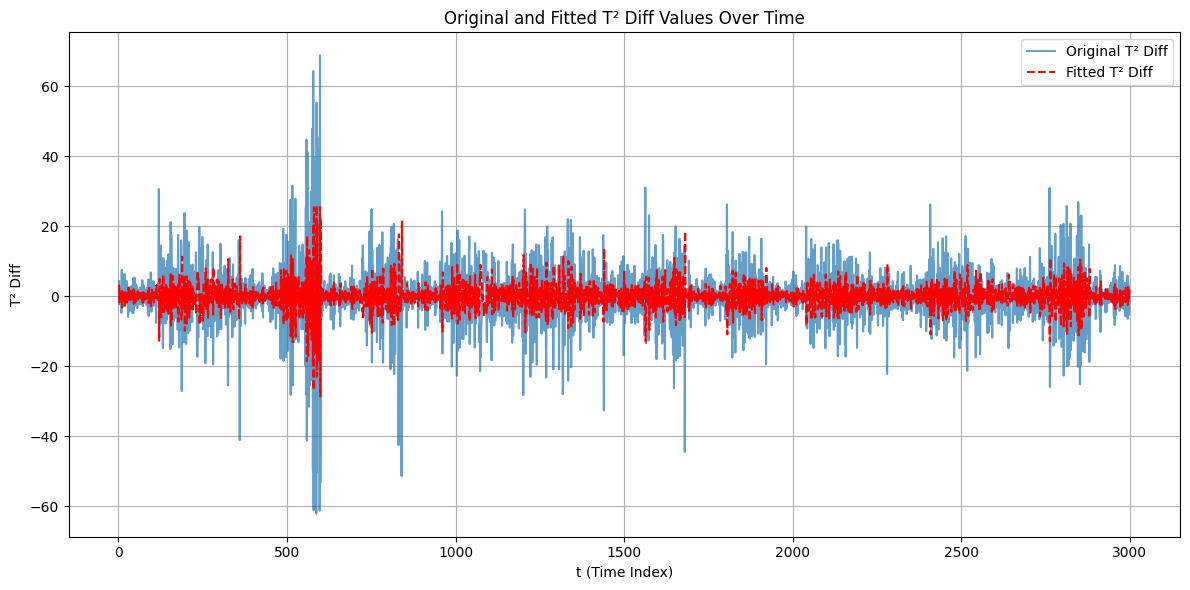

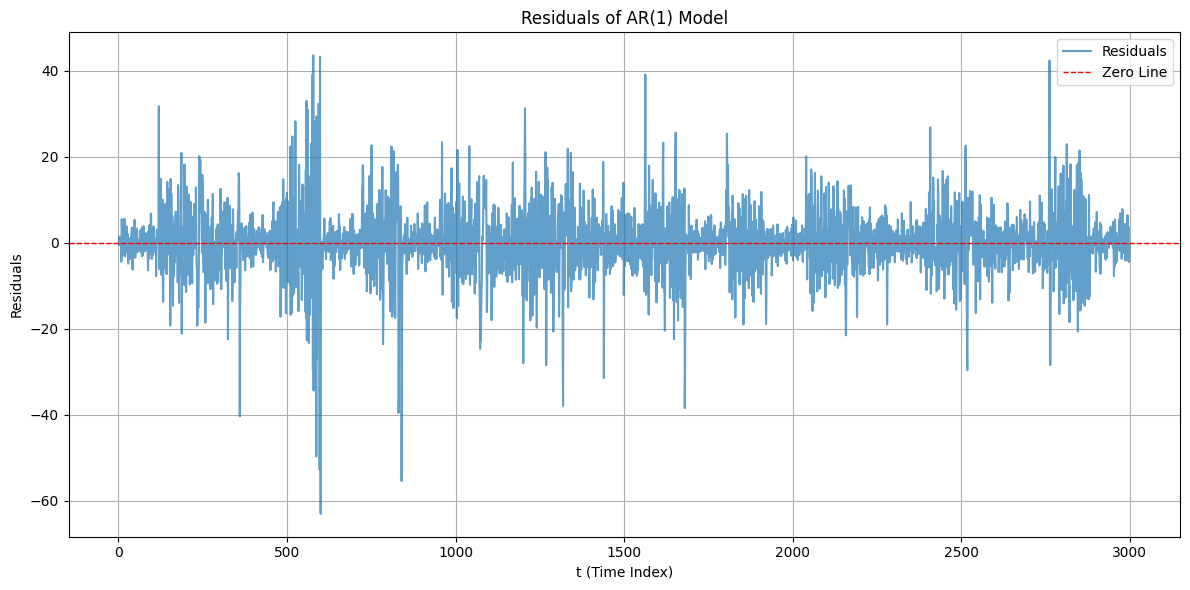

In [19]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AR(1) model
ar_model = AutoReg(pca_rowwise_df['T2_diff'], lags=1).fit()

# Print the summary of the model
print(ar_model.summary())

# Plot the original values and the fitted values
plt.figure(figsize=(12, 6))
plt.plot(pca_rowwise_df['t'][1:], pca_rowwise_df['T2_diff'][1:], label='Original T² Diff', alpha=0.7)
plt.plot(pca_rowwise_df['t'][1:], ar_model.fittedvalues, label='Fitted T² Diff', linestyle='--', color='red')
plt.xlabel('t (Time Index)')
plt.ylabel('T² Diff')
plt.title('Original and Fitted T² Diff Values Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate residuals
residuals = pca_rowwise_df['T2_diff'][1:] - ar_model.fittedvalues

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(pca_rowwise_df['t'][1:], residuals, label='Residuals', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.xlabel('t (Time Index)')
plt.ylabel('Residuals')
plt.title('Residuals of AR(1) Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term   Coef  SE Coef  T-Value  P-Value
ar.L1 -0.416    0.007 -59.6118      0.0

RESIDUAL SUM OF SQUARES
-------------------------
    DF          SS      MS
2997.0 181038.5697 60.4066

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square    P-Value
  12    191.3659 1.9655e-34
  24    286.6980 7.9051e-47
  36    340.5846 2.9350e-51
  48    358.0551 5.1676e-49


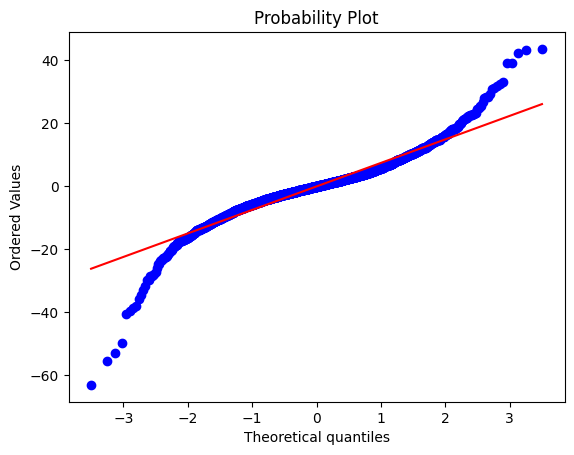

Shapiro-wilk test statistic = 0.923
Shapiro-wilk test p-value = 0.000
Runs test statistic = 0.365
Runs test p-value = 0.715



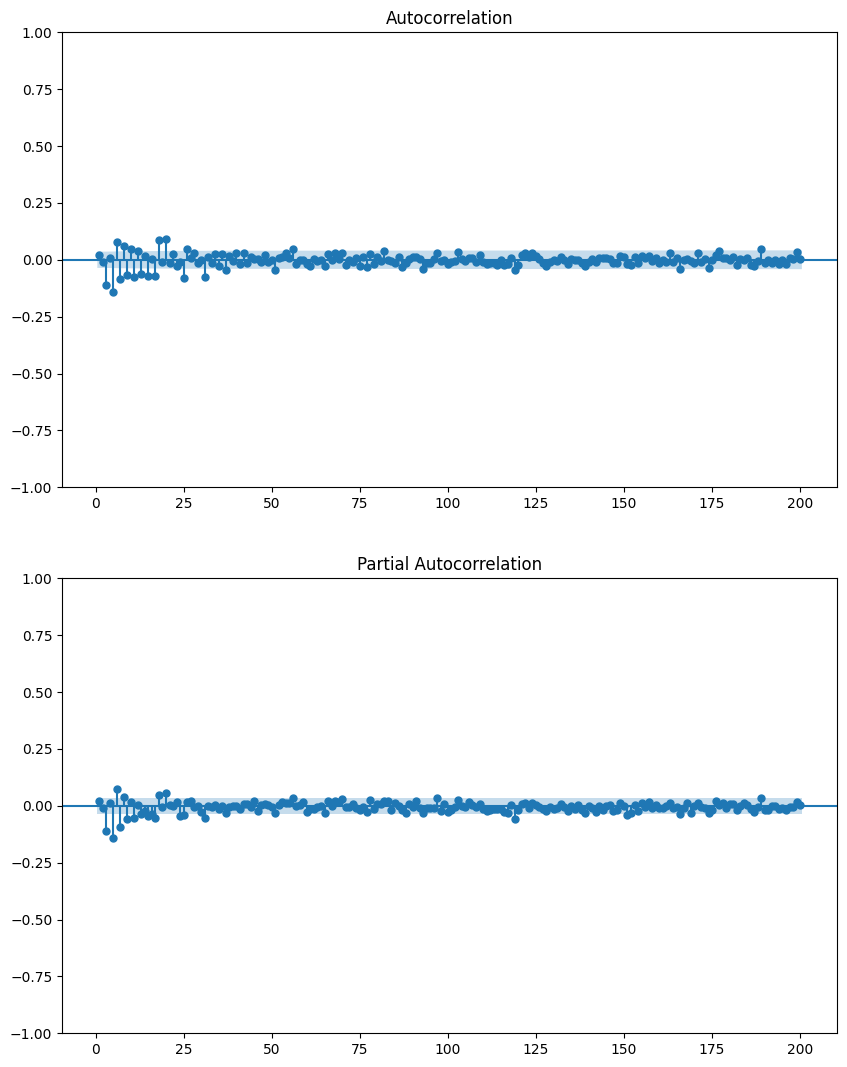

In [23]:
x = pca_rowwise_df['T2']
model = qda.ARIMA(x, order=(1,1,0), add_constant = False) 

qda.ARIMAsummary(model)

#extract the residuals
residuals = model.resid[1:]

_ = qda.Assumptions(residuals).normality()

_ = qda.Assumptions(residuals).independence()

In [27]:
from scipy.stats import t, kstest

# Fit the t-distribution to the residuals
params = t.fit(residuals)

# Perform the Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = kstest(residuals, 't', args=params)

print(f"K-S Statistic: {ks_statistic}")
print(f"P-Value: {ks_pvalue}")

if ks_pvalue > 0.05:
    print("Residuals likely follow a t-Student distribution (fail to reject null hypothesis).")
else:
    print("Residuals do not follow a t-Student distribution (reject null hypothesis).")

K-S Statistic: 0.013005134203895374
P-Value: 0.6859730875240803
Residuals likely follow a t-Student distribution (fail to reject null hypothesis).


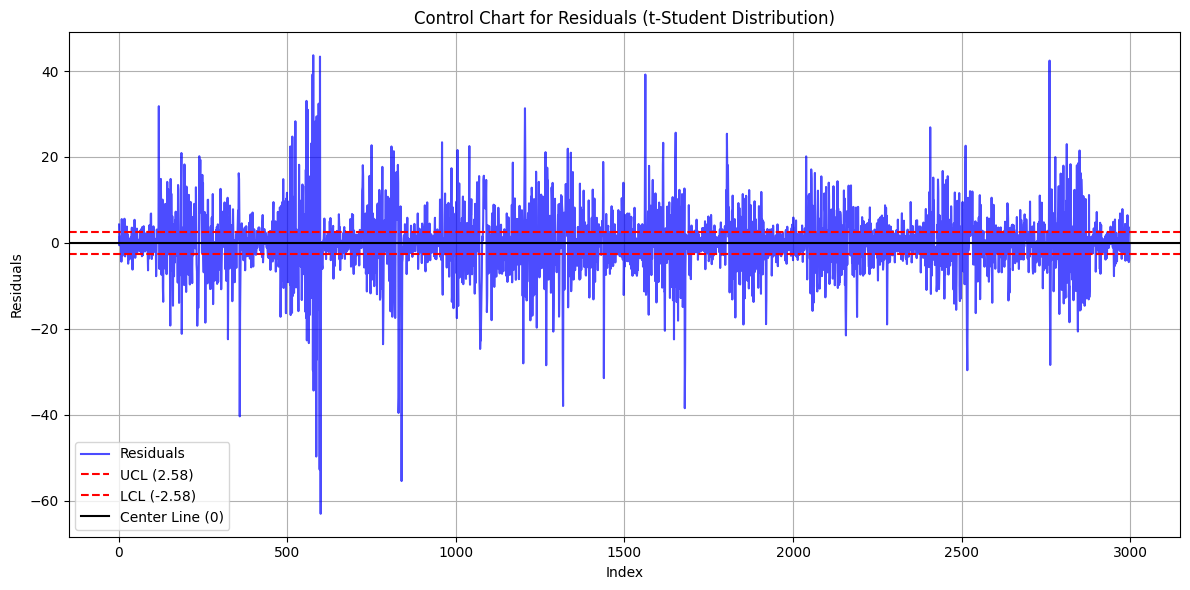

In [29]:
from scipy.stats import t

import matplotlib.pyplot as plt

# Degrees of freedom for the t-distribution
df = len(residuals) - 1

# Confidence level for control limits (e.g., 99%)
confidence_level = 0.99
alpha = 1 - confidence_level

# Calculate control limits
t_critical = t.ppf(1 - alpha / 2, df)
ucl = t_critical
lcl = -t_critical

# Plot the control chart
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='blue', alpha=0.7)
plt.axhline(ucl, color='red', linestyle='--', label=f'UCL ({ucl:.2f})')
plt.axhline(lcl, color='red', linestyle='--', label=f'LCL ({lcl:.2f})')
plt.axhline(0, color='black', linestyle='-', label='Center Line (0)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Control Chart for Residuals (t-Student Distribution)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

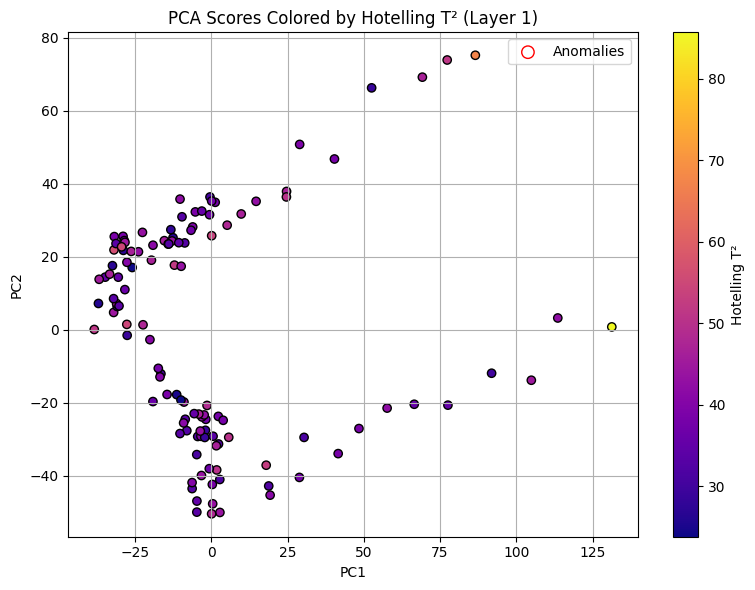

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import f

def plot_pca_hotelling_layer(matrix, confidence=0.95):
    # Step 1: Apply PCA (keep all components for accurate T², but plot first 2)
    pca = PCA(n_components=0.90)
    scores = pca.fit_transform(matrix)
    std_devs = np.sqrt(pca.explained_variance_)
    
    # Step 2: Compute Hotelling T² for each sample
    t2 = np.sum((scores / std_devs) ** 2, axis=1)

    # Step 3: Plot in first 2 PCs
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(scores[:, 0], scores[:, 1], c=t2, cmap='plasma', edgecolor='k')
    plt.colorbar(sc, label="Hotelling T²")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Scores Colored by Hotelling T² (Layer 1)')
    plt.grid(True)

    # Step 4: Plot threshold ellipse (optional)
    n, p = matrix.shape[0], scores.shape[1]
    f_crit = f.ppf(confidence, p, n - p)
    t2_thresh = (p * (n - 1) / (n - p)) * f_crit

    # Show samples with T² > threshold
    outliers = np.where(t2 > t2_thresh)[0]
    plt.scatter(scores[outliers, 0], scores[outliers, 1], edgecolors='red', facecolors='none', s=80, label='Anomalies')

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_hotelling_layer(list_25l[0])
